In [1]:
import sys
import os
path = os.path.abspath("../")
sys.path.append(path)
print(path)

/home/jovyan


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset, Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random

from collections import defaultdict, Counter
from line_profiler import profile
from scipy.linalg import orthogonal_procrustes

import src.data_processing.ImageCalculations as imgcalc
import src.visualization.ImagePlots as imgplt
import src.helpers.ModelUtilities as models
import src.helpers.TCNNModelUtilities as tcnnmodels
import src.data_processing.Utilities as utils
import src.helpers.FilepathUtils as Futils
import src.data_processing.EmbeddingFunctions as embedfunc
import src.data_processing.ImageProducts as ImageProducts
import src.helpers.MetricUtilities as metrics

from src.visualization import BFmethod
from functools import partial
from learnable_polyphase_sampling.learn_poly_sampling.layers import get_logits_model, PolyphaseInvariantDown2D, LPS
from learnable_polyphase_sampling.learn_poly_sampling.layers.polydown import set_pool

from mtree.mtree import MTree
import mtree.mtree as mtree

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

%reload_ext autoreload

%autoreload 2

cpu


In [ ]:
import sys
import os
path = os.path.abspath("../")
sys.path.append(path)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset, Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random

from collections import defaultdict, Counter
from line_profiler import profile
from scipy.linalg import orthogonal_procrustes

import src.data_processing.ImageCalculations as imgcalc
import src.visualization.ImagePlots as imgplt
import src.helpers.ModelUtilities as models
import src.helpers.TCNNModelUtilities as tcnnmodels
import src.data_processing.Utilities as utils
import src.helpers.FilepathUtils as Futils
import src.data_processing.EmbeddingFunctions as embedfunc
import src.data_processing.ImageProducts as ImageProducts
import src.helpers.MetricUtilities as metrics

from src.visualization import BFmethod
from functools import partial
from learnable_polyphase_sampling.learn_poly_sampling.layers import get_logits_model, PolyphaseInvariantDown2D, LPS
from learnable_polyphase_sampling.learn_poly_sampling.layers.polydown import set_pool

from mtree.mtree import MTree
import mtree.mtree as mtree

import glob
from PIL import Image

import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TODO: Put these in a separate file for MTreeUtils...
def getKNearestNeighbours(tree, point, k):
    l = tree.search(point, k)
    imgs = list(l)
    return imgs

def getMTree(data, k):
    # k: desired number of nearest neighbours
    tree = MTree(metrics.distance, max_node_size=k)
    tree.add_all(data)
    return tree

class CustomDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

        self.imgs_path = "../data/imdb_wiki/"
        file_list = glob.glob(self.imgs_path + "*")
        self.images = []
        for class_path in file_list:
            for dir_path in glob.glob(class_path + "/*"):
                for img_path in glob.glob(dir_path + "/*.jpg"):
                    self.images.append(img_path)

    # Defining the length of the dataset
    def __len__(self):
        return len(self.images)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path)
        image = transforms.functional.to_grayscale(image)

        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy()

class CustomDatasetMStar(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

        self.imgs_path = "../data/mstar/Padded_imgs/"
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.JPG"):
                self.data.append([img_path, class_name])
        #print(self.data)
        self.class_map = {"2S1" : 0, "BRDM_2": 1, "BTR_60": 2, "D7": 3, "SLICY": 4, "T62": 5, "ZIL131": 6, "ZSU_23_4": 7}

    # Defining the length of the dataset
    def __len__(self):
        return len(self.images)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        data_path = self.data[index]
        image = Image.open(data_path[0])
        image = transforms.functional.to_grayscale(image)
        class_id = self.class_map[data_path[1]]
        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy(), class_id

def get_data(size):
    transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    return CustomDataset(transform)

def get_data_MStar(size):
    transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    return CustomDatasetMStar(transform)

def plot_data_mtree_ncc(x_axis="", title="", filename="", varied_arr=[], data1=[], data2=[], max_node_size=12):
    data_ncc = []
    data_mtree = []
    for i in range(len(varied_arr)):
        data_ncc.append([varied_arr[i], data1[i]])
        data_mtree.append([varied_arr[i], data2[i]])

    # print(data_ncc)
    # print(data_mtree)
    data_ncc = np.array(data_ncc)
    data_mtree = np.array(data_mtree)
    x_ncc, y_ncc = data_ncc.T
    x_mtree, y_mtree = data_mtree.T

    plt.plot(x_ncc, y_ncc, label = "ncc search", linestyle="-")
    plt.plot(x_mtree, y_mtree, label = f"mtree search, node size {max_node_size}", linestyle="--")
    plt.legend()
    plt.xlabel(x_axis)  # Title for the x-axis
    plt.ylabel("Runtime (s)")  # Title for the y-axis
    plt.title(title)
    # note its over 5 runs
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight', dpi=1000)

def plot_data_mtree_init(x_axis="", title="", filename="", varied_arr=[], data=[], max_node_size=12):
    data_mtree_init = []
    for i in range(len(varied_arr)):
        data_mtree_init.append([varied_arr[i], data[i]])

    data_mtree_init = np.array(data_mtree_init)

    x_mtree_init, y_mtree_init = data_mtree_init.T

    plt.plot(x_mtree_init, y_mtree_init, label = f"mtree init", linestyle="-")
    plt.legend()
    plt.xlabel(x_axis)
    plt.ylabel("Runtime (s)")
    plt.title(title)
    # note its over 3 runs
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight', dpi=1000)

def plot_data_matG_init(x_axis="", title="", filename="", varied_arr=[], data=[]):
    data_init = []
    for i in range(len(varied_arr)):
        data_init.append([varied_arr[i], data[i]])

    data_init = np.array(data_init)

    x, y = data_init.T

    plt.plot(x, y, label = f"matG init", linestyle="-")
    plt.legend()
    plt.xlabel(x_axis)
    plt.ylabel("Runtime (s)")
    plt.title(title)
    # note its over 3 runs
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight', dpi=1000)

random.seed(42)

def mtree_ncc_query_sample_size(max_node_size=12, image_size=32, k=7, runs=2, sample_sizes=[1]):
    total_time_ncc = 0
    total_time_mtree = 0
    avg_times_ncc = []
    avg_times_mtree = []

    IMDB_WIKI_data = get_data(image_size)

    print(f"Average runtime of querying mtree and ncc for {k} NN over {runs} runs with image size {image_size} and max node size {max_node_size} and variable sample size")
    for i in range(len(sample_sizes)):
        print(f"NOW TRYING sample size: {sample_sizes[i]}")
        total_time_ncc = 0
        total_time_mtree = 0

        sample_indices = random.sample(range(len(IMDB_WIKI_data)), sample_sizes[i])
        sampled_test_data = Subset(IMDB_WIKI_data, sample_indices)

        testSample = sampled_test_data
        

        tree = getMTree(testSample, max_node_size)

        # trans = transforms.Compose([transforms.Resize(img_sizes[i])])
        # t_MNIST_data = trans(MNIST_data)

        # for img in MNIST_data:
        #     img = trans(img)

        for _ in range(runs):
            index1 = np.random.randint(len(IMDB_WIKI_data))
            #input1=input_dataset[index1][0].squeeze().to('cpu')
            unseen_image = IMDB_WIKI_data[index1]

            start_time = time.time()
            arr = []
            for j in range(len(testSample)):
                result = ImageProducts.ncc_scaled(testSample[j], unseen_image)
                arr.append(result)
            
            unseen_img_arr = np.array(arr)
            #print(unseen_img_arr)
            imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
            end_time = time.time()

            total_time_ncc += end_time - start_time

            start_time = time.time()
            imgs = getKNearestNeighbours(tree, unseen_image, k+1)
            # return [imgs, imgProd_max_index, index1, testSample]
            end_time = time.time()
            total_time_mtree += end_time - start_time

        avg_ncc = total_time_ncc / runs
        avg_mtree = total_time_mtree / runs
        avg_times_ncc.append(avg_ncc)
        avg_times_mtree.append(avg_mtree)

        with open("test_mtree_query_sample_sizes_avg_times_ncc_.txt", "w") as file:
            file.write(f"avg times: {str(avg_times_ncc)}")
        
        with open("test_mtree_query_sample_sizes_avg_times_mtree_.txt", "w") as file:
            file.write(f"avg times: {str(avg_times_mtree)}")

        print(f"Average runtime of ncc search: {avg_ncc:.6f} seconds")
        print(f"Average runtime of mtree search: {avg_mtree:.6f} seconds")
    plot_data_mtree_ncc(x_axis="Sample size", title=f"Average runtime of finding {k} neighbours with image size {image_size} against sample sizes", filename="test_mtree_query_sample_sizes.png", 
                        varied_arr=sample_sizes, data1=avg_times_ncc, data2=avg_times_mtree, max_node_size=max_node_size)
    

def mtree_init_sample_size(max_node_size=12, image_size=32, k=7, runs=2, sample_sizes=[1]):
    total_time_mtree_init = 0
    avg_times_mtree_init = []

    IMDB_WIKI_data = get_data(image_size)

    print(f"Average runtime of initialising mtree over {runs} runs with max node size {max_node_size} and image size {image_size} and variable sample sizes")

    for i in range(len(sample_sizes)):
        print(f"NOW TRYING sample size: {sample_sizes[i]}")
        total_time_mtree_init = 0

        sample_indices = random.sample(range(len(IMDB_WIKI_data)), sample_sizes[i])
        sampled_test_data = Subset(IMDB_WIKI_data, sample_indices)

        testSample = sampled_test_data

        for _ in range(runs):
            start_time = time.time()
            tree = getMTree(testSample, max_node_size)
            end_time = time.time()
            total_time_mtree_init += end_time - start_time
            print(f"Finished one run of mtree init...")

        
        avg_mtree_init = total_time_mtree_init / runs
        avg_times_mtree_init.append(avg_mtree_init)

        
        with open("test_mtree_init_sample_sizes_avg_times_mtree_init.txt", "w") as file:
            file.write(f"avg times: {str(avg_times_mtree_init)}")

        print(f"Average runtime of mtree init: {avg_mtree_init:.6f} seconds")
    
    plot_data_mtree_init(x_axis="Sample size", title=f"Average runtime of initialising mtree with image size {image_size}, max node size {max_node_size} against sample sizes", filename="test_mtree_init_sample_sizes.png", 
                        varied_arr=sample_sizes, data=avg_times_mtree_init, max_node_size=max_node_size)
    

def mtree_init_img_size(max_node_size=12, image_sizes=[], k=7, runs=2, sample_size=5000):
    total_time_mtree_init = 0
    avg_times_mtree_init = []


    print(f"Average runtime of initialising mtree over {runs} runs with variable image sizes and sample size {sample_size} and max nodes size {max_node_size} ")

    for i in range(len(image_sizes)):
        IMDB_WIKI_data = get_data(image_sizes[i])
        print(f"NOW TRYING image size: {image_sizes[i]}")
        total_time_mtree_init = 0

        sample_indices = random.sample(range(len(IMDB_WIKI_data)), sample_size)
        sampled_test_data = Subset(IMDB_WIKI_data, sample_indices)

        testSample = sampled_test_data

        for _ in range(runs):
            start_time = time.time()
            tree = getMTree(testSample, max_node_size)
            end_time = time.time()
            total_time_mtree_init += end_time - start_time
            #print(f"Finished one run of mtree init...")

        
        avg_mtree_init = total_time_mtree_init / runs
        avg_times_mtree_init.append(avg_mtree_init)

        
        with open("test_mtree_init_image_sizes_avg_times_mtree_init.txt", "w") as file:
            file.write(f"avg times: {str(avg_times_mtree_init)}")

        print(f"Average runtime of mtree init: {avg_mtree_init:.6f} seconds")
    
    plot_data_mtree_init(x_axis="Image size", title=f"Average runtime of initialising mtree with sample size {sample_size} and max node size {max_node_size} against image sizes", filename="test_mtree_init_image_sizes_max_node_12.png", 
                        varied_arr=image_sizes, data=avg_times_mtree_init, max_node_size=max_node_size)

def matG_init_sample_size(image_size=32, k=7, runs=2, sample_sizes=[1]):
    total_time_matG_init = 0
    avg_times_matG_init = []

    IMDB_WIKI_data = get_data(image_size)

    print(f"Average runtime of initialising matG over {runs} runs with image size {image_size} and variable sample sizes")

    for i in range(len(sample_sizes)):
        print(f"NOW TRYING sample size: {sample_sizes[i]}")
        total_time_matG_init = 0

        sample_indices = random.sample(range(len(IMDB_WIKI_data)), sample_sizes[i])
        sampled_test_data = Subset(IMDB_WIKI_data, sample_indices)

        testSample = sampled_test_data

        for _ in range(runs):
            start_time = time.time()
            matG = imgcalc.get_matrixG(testSample, "ncc_scaled_-1")
            end_time = time.time()
            total_time_matG_init += end_time - start_time
            print(f"Finished one run of matG init...")

        
        avg_matG_init = total_time_matG_init / runs
        avg_times_matG_init.append(avg_matG_init)

        
        with open("test_matG_init_sample_sizes_avg_times_matG_init.txt", "w") as file:
            file.write(f"avg times: {str(avg_times_matG_init)}")

        print(f"Average runtime of matG init: {avg_matG_init:.6f} seconds")
    
    plot_data_matG_init(x_axis="Sample size", title=f"Average runtime of initialising mat G with image size {image_size}, against sample sizes", filename="test_matG_init_sample_sizes.png", 
                        varied_arr=sample_sizes, data=avg_times_matG_init)
    

def matG_init_img_size(image_sizes=[], k=7, runs=2, sample_size=5000):
    total_time_matG_init = 0
    avg_times_matG_init = []

    

    print(f"Average runtime of initialising matG over {runs} runs with sample size {sample_size} and variable image sizes")

    for i in range(len(image_sizes)):
        print(f"NOW TRYING image size: {image_sizes[i]}")
        total_time_matG_init = 0

        IMDB_WIKI_data = get_data(image_sizes[i])
        sample_indices = random.sample(range(len(IMDB_WIKI_data)), sample_size)
        sampled_test_data = Subset(IMDB_WIKI_data, sample_indices)

        testSample = sampled_test_data

        for _ in range(runs):
            start_time = time.time()
            matG = imgcalc.get_matrixG(testSample, "ncc_scaled_-1")
            end_time = time.time()
            total_time_matG_init += end_time - start_time
            print(f"Finished one run of matG init...")

        
        avg_matG_init = total_time_matG_init / runs
        avg_times_matG_init.append(avg_matG_init)

        
        with open("test_matG_init_image_sizes_avg_times_matG_init.txt", "w") as file:
            file.write(f"avg times: {str(avg_times_matG_init)}")

        print(f"Average runtime of matG init: {avg_matG_init:.6f} seconds")
    
    plot_data_matG_init(x_axis="Image size", title=f"Average runtime of initialising mat G with sample size {sample_size}, against image sizes", filename="test_matG_init_image_sizes.png", 
                        varied_arr=image_sizes, data=avg_times_matG_init)

Average runtime of initialising mtree over 100 runs with variable image sizes and sample size 100 and max nodes size 12 
NOW TRYING image size: 32
Average runtime of mtree init: 0.747952 seconds
NOW TRYING image size: 64
Average runtime of mtree init: 2.088908 seconds
NOW TRYING image size: 128
Average runtime of mtree init: 5.457029 seconds
NOW TRYING image size: 140
Average runtime of mtree init: 5.195702 seconds
NOW TRYING image size: 160
Average runtime of mtree init: 6.875970 seconds
NOW TRYING image size: 180
Average runtime of mtree init: 15.884072 seconds
NOW TRYING image size: 200
Average runtime of mtree init: 15.043453 seconds


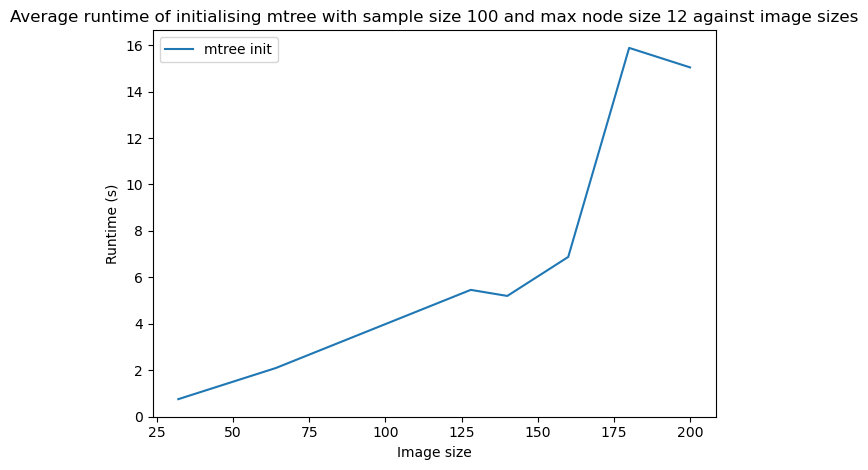

In [9]:
k = 7
image_size = 16
max_node_size = 12
sample_size = 500
image_sizes = [32, 64, 128, 140, 160, 180, 200]
sample_sizes = [1000, 5000, 10000, 20000, 50000, 100000, 200000, 300000, 400000, 500000]
avg_times_ncc = [3.336286, 3.696705, 4.711594, 4.758202, 4.852191, 7.087710, 7.810045]
avg_times_mtree = [0.070414, 0.297683, 1.251325, 1.247262, 1.297005, 3.368683, 3.835782]


avg_times_mtree_init = [86.425924, 182.267726, 1449.868364, 1830.932521, 1879.792569, 1830.305575]


mtree_init_img_size(max_node_size=12, image_sizes=image_sizes, k=7, runs=100, sample_size=100)


# I'll prolly try to run matG and tree init for imgsize 16...? with matG just up to 100k... hopefully that could still work

In [7]:
def img_list_to_distances(arr, point):
    dist_arr = []
    for i in range(len(arr)):
        if (arr[i] is not None):
            dist_arr.append(metrics.distance(arr[i], point))
    
    return dist_arr

def check_in_dist_arr(arr, dist):
    t = 0.0001 # threshold
    for d in arr:
        #print("DISTANCE {} VS TREE DISTANCE: {}".format(dist, d))
        if (dist >= d - t and dist <= d + t):
            return True
    return False

def getKNearestNeighbours(tree, point, k):
    l = tree.search(point, k)
    imgs = list(l)
    return imgs

def getMTree(data, k):
    # k: desired number of nearest neighbours
    tree = MTree(metrics.distance, max_node_size=k)
    tree.add_all(data)
    return tree



In [5]:
import glob
import cv2
from PIL import Image

# yippee its working.

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])   

class CustomDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

        self.imgs_path = "../data/imdb_wiki/"
        file_list = glob.glob(self.imgs_path + "*")
        self.images = []
        for class_path in file_list:
            for dir_path in glob.glob(class_path + "/*"):
                for img_path in glob.glob(dir_path + "/*.jpg"):
                    self.images.append(img_path)

    # Defining the length of the dataset
    def __len__(self):
        return len(self.images)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path)
        image = transforms.functional.to_grayscale(image)

        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy()

class CustomDatasetMStar(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

        self.imgs_path = "../data/mstar/Padded_imgs/"
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.JPG"):
                self.data.append([img_path, class_name])
        #print(self.data)
        self.class_map = {"2S1" : 0, "BRDM_2": 1, "BTR_60": 2, "D7": 3, "SLICY": 4, "T62": 5, "ZIL131": 6, "ZSU_23_4": 7}

    # Defining the length of the dataset
    def __len__(self):
        return len(self.data)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        data_path = self.data[index]
        image = Image.open(data_path[0])
        image = transforms.functional.to_grayscale(image)
        class_id = self.class_map[data_path[1]]
        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy(), class_id

def get_data(size):
    transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    return CustomDataset(transform)

def get_data_MStar(size):
    transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    return CustomDatasetMStar(transform)

9466


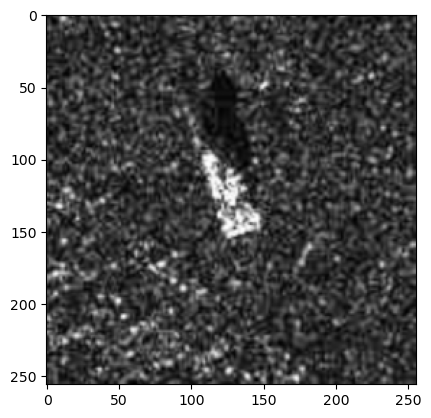

In [ ]:
# note MStar is 368 by 368...
dataset = get_data_MStar(256)


print(len(dataset))
test_img, test_class = dataset[1]
#print(test)

plt.imshow(test_img, cmap='grey')
plt.show()
# full_dataset = []
# for i in range(len(dataset)):
#     full_dataset.append(dataset[i])

# print(full_dataset)
#print(dataset)
#data_loader = DataLoader(dataset, batch_size=4, shuffle=True)



# imgs_path = "../data/imdb_wiki/"
# file_list = glob.glob(imgs_path + "*")
# print(file_list)


## Getting data

In [5]:
# ----------------------------------Image Input----------------------------------
IMAGE_TYPES = ["NbinMmax_ones", "Nbin", "triangles", "triangle_mean_subtracted"]

IMAGE_FILTERS = ["unique", "Nmax_ones", "one_island"]

IMAGE_PRODUCT_TYPES = ["ncc", "ncc_scaled"]

EMBEDDING_TYPES = ["pencorr_D"]


dimensions = 256
imageProductType = "ncc_scaled_-1"
overwrite = {"imgSet": False, "imgProd": False, "embedding": False}
weight = None
embeddingType = f"pencorr_{dimensions}"
k = 5
imageType = "MNIST"

model_directory = "model"

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

MNIST_data_train = torchvision.datasets.MNIST(root="../data", train=True, transform=transform)
MNIST_data_test = torchvision.datasets.MNIST(root="../data", train=False, transform=transform)
MNIST_data = MNIST_data_train + MNIST_data_test
print(len(MNIST_data)) #Total unique images: 10000
#print(len(MNIST_data_test))

random.seed(42)
# normally its 500
sample_indices = random.sample(range(len(MNIST_data)), 70000)
sampled_test_data = Subset(MNIST_data, sample_indices)
unseen_image = MNIST_data[-1][0].squeeze().squeeze().cpu().numpy().astype(np.float32)

input_dataset = []
testSample = []
num = len(sampled_test_data)
for i in range(len(sampled_test_data)):
    img_tensor = sampled_test_data[i][0] 
    input_dataset.append(img_tensor.unsqueeze(0).to(device).float())
    img_numpy = img_tensor.squeeze().squeeze().cpu().numpy().astype(np.float32)
    testSample.append(img_numpy)
    #print(img_numpy)


print(len(testSample))

70000
70000


## Testing mtree search function

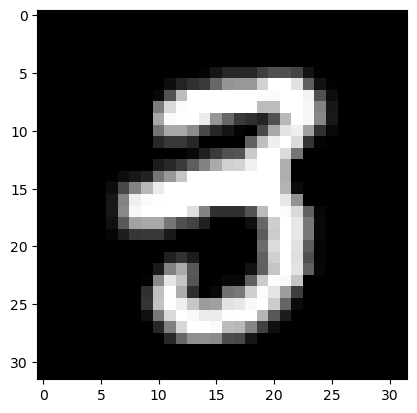

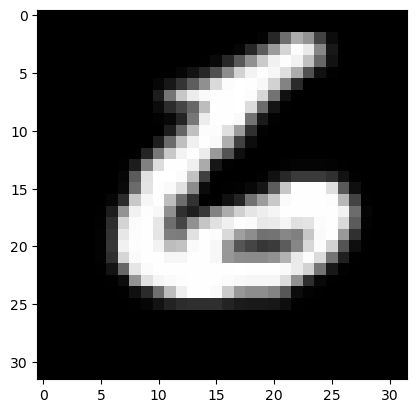

In [259]:
index1 = np.random.randint(len(testSample))
input1=input_dataset[index1][0].squeeze().to('cpu')
#index2 = np.random.randint(len(testSample))
#input2=input_dataset[index2][0].squeeze().to('cpu')
plt.imshow(testSample[index1], cmap='grey')
plt.show()

plt.imshow(unseen_image, cmap='grey')
plt.show()

In [76]:
arr = [2,3,4,5,6]
with open("test.txt", "w") as file:
    file.write(f"mtree array: {str(arr)}")

# ok this works


In [242]:
from mtree.mtree import MTree
import mtree.mtree as mtree


k=8

def tree_len(tree):
    """Count the number of element in a tree by inspecting the nodes"""
    def node_len(node):
        if isinstance(node, mtree.InternalNode):
            return sum(node_len(e.subtree) for e in node.entries)
        else:
            return len(node.entries)
    return node_len(tree.root)

# Note it can only find up to max_node_size nearest neighbors...
tree = MTree(metrics.distance, max_node_size=k)
tree.add_all(testSample)
print(tree_len(tree))

500


In [157]:
k=8
test_img = input1.numpy().astype(np.float32)
#k = 5
l = tree.search(test_img, k)
imgs = list(l)
#print(imgs)
for i in range(k):
    if (imgs[i] is not None):
        #imgplt.plot_original_images(imgs[i], testSample[0], 10, 0)
        print(metrics.distance(imgs[i], test_img))

0.00021980378921607072
0.2763427044773527


In [ ]:
from itertools import combinations, islice

k=8


# img1, img2 = max(combinations(testSample[0:4], 2), key=lambda two_objs: metrics.distance(*two_objs))
# index1 = 0
# index2 = 0
# for i in range(4):
#     if (img1 == testSample[i]).all():
#         index1 = i
#     elif (img2 == testSample[i]).all():
#         index2 = i

# print((index1, index2))

def num_of_no_none(mtree, query, k):
    l = mtree.search(query, k)
    imgs = list(l)
    n = 0
    for i in range(k):
        if (imgs[i] is not None):
            n += 1

    return True if n == k else False

num_working = 0
for i in range(len(testSample)):
    index1 = i
    input1=input_dataset[index1][0].squeeze().to('cpu')
    test_img = input1.numpy().astype(np.float32)
    if (num_of_no_none(tree, test_img, k)):
        num_working += 1
    else:
        plt.imshow(testSample[i], cmap="gray")
        plt.title("Index {}".format(i))
        l = tree.search(testSample[i], k)
        imgs = list(l)
        for j in range(len(imgs)):
            if (imgs[j] is not None):
                print(metrics.distance(imgs[j], testSample[i]))
        #print(list(l))
        plt.show()

# l = tree.search(testSample[4], k)
# imgs = list(l)
# for j in range(len(imgs)):
#     if (imgs[j] is not None):
#         print(metrics.distance(imgs[j], testSample[4]))

# root = tree.get_root()
# objs = root.print_subtrees()
# objs1 = objs[0]
# objs2 = objs[1]
# indices1 = []
# indices2 = []
# for i in range(len(objs1)):
#     for j in range(len(testSample)):
#         if ((objs1[i] == testSample[j]).all()):
#             indices1.append(j)

# for i in range(len(objs2)):
#     for j in range(len(testSample)):
#         if ((objs2[i] == testSample[j]).all()):
#             indices2.append(j)


#print(indices1, indices2)
print(num_working)

500


In [101]:
matrixG = imgcalc.get_matrixG(testSample, imageProductType)
#matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)

In [7]:
k = 7

def img_list_to_distances(arr, point):
    dist_arr = []
    for i in range(len(arr)):
        if (arr[i] is not None):
            dist_arr.append(metrics.distance(arr[i], point))
    
    return dist_arr

def check_in_dist_arr(arr, dist):
    t = 0.0001 # threshold
    for d in arr:
        #print("DISTANCE {} VS TREE DISTANCE: {}".format(dist, d))
        if (dist >= d - t and dist <= d + t):
            return True
    return False

def getKNearestNeighbours(tree, point, k):
    l = tree.search(point, k)
    imgs = list(l)
    return imgs

def getMTree(data, k):
    # k: desired number of nearest neighbours
    tree = MTree(metrics.distance, max_node_size=k)
    tree.add_all(data)
    return tree

# tree = getMTree(testSample, k+1)

# #imgs = getKNearestNeighbours(tree, input1.numpy(), k)
# #dist_arr = img_list_to_distances(imgs, input1.numpy())
# imgs = getKNearestNeighbours(tree, input1.numpy(), k+1)

# for i in range(k):
#     if (imgs[i] is not None):
#         #imgplt.plot_original_images(imgs[i], testSample[0], 10, 0)
#         print(metrics.distance(imgs[i], input1.numpy()))


## Testing accuracy of MTree search

In [ ]:




# print("----------------\nBrute Force Method -- KNN-IOU score\n----------------")
# test_img = input1.numpy().astype(np.float32)

# vectorb_bf1 = matrixG[index1]
# img_prod_indices = imgcalc.get_kNN_imageprod(vectorb_bf1, k)

# num_of_same = 0

# tree = getMTree(testSample, k+1)
# #print(tree_len(tree))

# imgs = getKNearestNeighbours(tree, test_img, k+1)
# dist_arr = img_list_to_distances(imgs, test_img)

# #print(imgs)
# print(dist_arr)

# for i in img_prod_indices:
#     dist = metrics.distance(test_img, testSample[i])
#     print("DISTANCES FOR {} with dist {}: ".format(i, dist))
#     if (check_in_dist_arr(dist_arr, dist)):
#         num_of_same += 1

# #print(num_of_same / (2 * (k - num_of_same) + num_of_same))
# print(num_of_same)

#top_values_b_1, _ = imgcalc.get_top_scores(vectorb_bf1, len(indices), vectorc_bf1)
#bottom_values_b_1, _ = imgcalc.get_bottom_scores(vectorb_bf1, len(indices), vectorc_bf1)

num_working = 0
tree = getMTree(testSample, k+1)

for i in range(len(testSample)):
    index1 = i
    input1=input_dataset[index1][0].squeeze().to('cpu')
    
    test_img = input1.numpy().astype(np.float32)
    vectorb_bf1 = matrixG[index1]
    img_prod_indices = imgcalc.get_kNN_imageprod(vectorb_bf1, k)

    num_of_same = 0

    imgs = getKNearestNeighbours(tree, test_img, k+1)
    dist_arr = img_list_to_distances(imgs, test_img)

    for j in img_prod_indices:
        dist = metrics.distance(test_img, testSample[j])
        #print("DISTANCES FOR {} with dist {}: ".format(i, dist))
        if (check_in_dist_arr(dist_arr, dist)):
            num_of_same += 1
        
        if (num_of_same == k+1):
            num_working += 1

print(num_working)



500


## Testing runtime of MTree

In [ ]:
import timeit
import time

k = 7

# start_time = time.time()
# for i in range(3):
#     matrixG = imgcalc.get_matrixG(testSample, imageProductType)
# end_time = time.time()

# print(f"Average runtime of initialisation of matrixG over 3 runs: {(end_time - start_time) / 3:.6f} seconds")



# start_time = time.time()
# for i in range(3):
#     matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
# end_time = time.time()

# print(f"Average runtime of initialisation of matrixA over 3 runs: {(end_time - start_time) / 3:.6f} seconds")


start_time = time.time()
for i in range(3):
    tree = getMTree(testSample, 15)
end_time = time.time()

print(f"Average runtime of initialisation of mtree over 3 runs with max-node-size {15}: {(end_time - start_time) / 3:.6f} seconds")




Average runtime of initialisation of mtree over 3 runs with max-node-size 15: 4.127089 seconds


In [ ]:
# numbers below are with max node size 15
# for 2k matrix G takes like 3.5mins? and tree is like 20s i think.
# for 5k tree is 20+ seconds.
# for 10k tree took 50.5 seconds
# Didn't calc for 
#matrixG = imgcalc.get_matrixG(testSample, imageProductType)
tree = getMTree(testSample, 15)

KeyboardInterrupt: 

In [ ]:
# Slight improvement in time w max-node-size 15, k = 7, testSampleSize = 3000 (improvement of 0.01s) 0.22 0.21
# Slight improvement in time w max-node-size 15, k = 7, testSampleSize = 5000 (improvement of 0.06s) 0.56 0.48
# Improvement of 0.2s for testSampleSize = 10k
# Improvement of 3s for 70k... and taking around 9+mins to init. Why is it so diff from the IMDB...? Is it cause the imgs is mostly black? In which case the tree may perf worse? Would it
# show a bigger diff with larger images? Actl ah....
runs = 1
total_time_bf  = 0
total_time_matG = 0
total_time_mtree = 0
k = 7

tree = getMTree(testSample, 12)


for i in range(runs):
    index1 = np.random.randint(70000)
    #input1=input_dataset[index1][0].squeeze().to('cpu')
    unseen_image = MNIST_data[index1][0].squeeze().squeeze().cpu().numpy().astype(np.float32)



    
    # start_time = time.time()
    # vectorc_bf1 = imgcalc.get_vectorc_brute(index1, matrixA)
    # embProd_max_index = np.argpartition(vectorc_bf1, -(k+1))[-(k+1):]
    # #imgProd_max_index = np.argpartition(matrixG[index1], -(k+1))[-(k+1):]
    # end_time = time.time()
    # total_time_bf += end_time - start_time

    start_time = time.time()
    arr = []
    for i in range(len(testSample)):
        result = ImageProducts.ncc_scaled(testSample[i], unseen_image)
        arr.append(result)
    
    unseen_img_arr = np.array(arr)
    #unseen_img_arr = np.atleast_2d(arr)
    #new_matG = np.append(matrixG, unseen_img_arr, axis=0)
    #print(new_matG[-1])
    #imgProd_max_index = np.argpartition(new_matG[-1], -(k+1))[-(k+1):]
    imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
    end_time = time.time()

    total_time_matG += end_time - start_time

    start_time = time.time()
    imgs = getKNearestNeighbours(tree, unseen_image, k+1)
    end_time = time.time()
    total_time_mtree += end_time - start_time

#print(f"Average runtime of finding {k} neighbours using brute force method over {runs} runs: {(total_time_bf) / runs:.6f} seconds")
print(f"Average runtime of finding {k} neighbours using matrix G over {runs} runs: {(total_time_matG) / runs:.6f} seconds")
print(f"Average runtime of finding {k} neighbours using mtree over {runs} runs: {(total_time_mtree) / runs:.6f} seconds")


Average runtime of finding 7 neighbours using matrix G over 1 runs: 9.992726 seconds
Average runtime of finding 7 neighbours using mtree over 1 runs: 6.436544 seconds


## Testing MTree initialisation timing with different parameters

In [44]:
# Vary sample size, img sizes, max_node_size

import time

img_sizes = [32, 64, 128, 140, 150, 180, 200]

sample_size = 5000 # size of image set
#img_size = 32 # length of square images
runs = 3 # number of runs to average result over
k = 7 # number of neighbours
max_node_size = 15 # max node size for MTree

# total_time_bf  = 0
total_time_mtree_init = 0
avg_times_mtree_init = []

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

MNIST_data_train = torchvision.datasets.MNIST(root="../data", train=True, transform=transform)
MNIST_data_test = torchvision.datasets.MNIST(root="../data", train=False, transform=transform)
MNIST_data = MNIST_data_train + MNIST_data_test

random.seed(42)
# normally its 500
sample_indices = random.sample(range(len(MNIST_data)), sample_size)
sampled_test_data = Subset(MNIST_data, sample_indices)

print(f"Average runtime of initialising mtree over {runs} runs with variable image sizes and sample size {sample_size} and max nodes size {max_node_size} ")

for i in range(len(img_sizes)):
    print(f"NOW TRYING image size: {img_sizes[i]}")
    total_time_mtree_init = 0

    # trans = transforms.Compose([transforms.Resize(img_sizes[i])])
    # t_MNIST_data = trans(MNIST_data)

    # for img in MNIST_data:
    #     img = trans(img)

    transform = transforms.Compose([
    transforms.Resize((img_sizes[i], img_sizes[i])),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

    MNIST_data_train = torchvision.datasets.MNIST(root="../data", train=True, transform=transform)
    MNIST_data_test = torchvision.datasets.MNIST(root="../data", train=False, transform=transform)
    MNIST_data = MNIST_data_train + MNIST_data_test

    random.seed(42)
    # normally its 500
    sample_indices = random.sample(range(len(MNIST_data)), sample_size)
    sampled_test_data = Subset(MNIST_data, sample_indices)

    input_dataset = []
    testSample = []
    num = len(sampled_test_data)
    for x in range(len(sampled_test_data)):
        img_tensor = sampled_test_data[x][0] 
        input_dataset.append(img_tensor.unsqueeze(0).to(device).float())
        img_numpy = img_tensor.squeeze().squeeze().cpu().numpy().astype(np.float32)
        testSample.append(img_numpy)
        #print(img_numpy)



    for _ in range(runs):
        start_time = time.time()
        tree = getMTree(testSample, max_node_size)
        end_time = time.time()
        total_time_mtree_init += end_time - start_time
        print(f"Finished one run of mtree init...")

    
    avg_mtree_init = total_time_mtree_init / runs
    avg_times_mtree_init.append(avg_mtree_init)

    print(f"Average runtime of mtree init: {avg_mtree_init:.6f} seconds")
    

Average runtime of initialising mtree over 3 runs with variable image sizes and sample size 5000 and max nodes size 15 
NOW TRYING image size: 32
Finished one run of mtree init...
Finished one run of mtree init...
Finished one run of mtree init...
Average runtime of mtree init: 29.000405 seconds
NOW TRYING image size: 64
Finished one run of mtree init...
Finished one run of mtree init...
Finished one run of mtree init...
Average runtime of mtree init: 103.413249 seconds
NOW TRYING image size: 128
Finished one run of mtree init...
Finished one run of mtree init...
Finished one run of mtree init...
Average runtime of mtree init: 431.310662 seconds
NOW TRYING image size: 140
Finished one run of mtree init...
Finished one run of mtree init...
Finished one run of mtree init...
Average runtime of mtree init: 433.758981 seconds
NOW TRYING image size: 150
Finished one run of mtree init...
Finished one run of mtree init...
Finished one run of mtree init...
Average runtime of mtree init: 427.977

In [46]:
print(avg_times_mtree_init)

[29.000404914220173, 103.4132486184438, 431.31066219011944, 433.758981068929, 427.977708419164, 1223.7831536134083, 1297.666079680125]


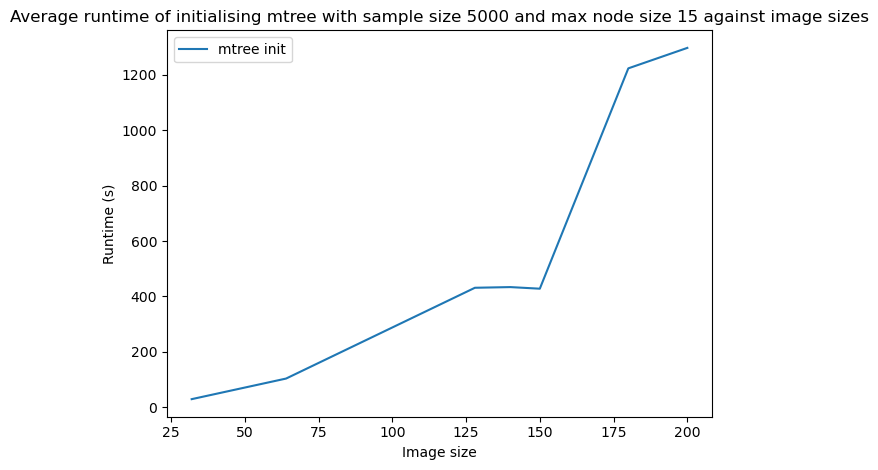

In [47]:
# # importing package
import matplotlib.pyplot as plt
import numpy as np

data_mtree_init = []
for i in range(len(img_sizes)):
    data_mtree_init.append([img_sizes[i], avg_times_mtree_init[i]])


data_mtree_init = np.array(data_mtree_init)

x_mtree_init, y_mtree_init = data_mtree_init.T

plt.plot(x_mtree_init, y_mtree_init, label = f"mtree init", linestyle="-")
plt.legend()
plt.xlabel("Image size")
plt.ylabel("Runtime (s)")
plt.title(f"Average runtime of initialising mtree with sample size {sample_size} and max node size {max_node_size} against image sizes")
# note its over 3 runs
plt.tight_layout()
plt.savefig("test_mtree_init_img_sizes.png", bbox_inches='tight', dpi=1000)
plt.show()

In [52]:
# Testing init time for different max node size

import time

image_size = 32
sample_size = 5000 # size of image set
#img_size = 32 # length of square images
runs = 3 # number of runs to average result over
k = 7 # number of neighbours
#max_node_size = 15 # max node size for MTree
max_node_sizes = [4, 6, 8, 10, 12, 14, 16, 18, 20]

# total_time_bf  = 0
total_time_mtree_init = 0
avg_times_mtree_init = []

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

MNIST_data_train = torchvision.datasets.MNIST(root="../data", train=True, transform=transform)
MNIST_data_test = torchvision.datasets.MNIST(root="../data", train=False, transform=transform)
MNIST_data = MNIST_data_train + MNIST_data_test

random.seed(42)
# normally its 500
sample_indices = random.sample(range(len(MNIST_data)), sample_size)
sampled_test_data = Subset(MNIST_data, sample_indices)

input_dataset = []
testSample = []
num = len(sampled_test_data)
for x in range(len(sampled_test_data)):
    img_tensor = sampled_test_data[x][0] 
    input_dataset.append(img_tensor.unsqueeze(0).to(device).float())
    img_numpy = img_tensor.squeeze().squeeze().cpu().numpy().astype(np.float32)
    testSample.append(img_numpy)
    #print(img_numpy)


print(f"Average runtime of initialising mtree over {runs} runs with variable max node size and sample size {sample_size} and image size {image_size} ")

for i in range(len(max_node_sizes)):
    print(f"NOW TRYING max node size: {max_node_sizes[i]}")
    total_time_mtree_init = 0

    # trans = transforms.Compose([transforms.Resize(img_sizes[i])])
    # t_MNIST_data = trans(MNIST_data)

    # for img in MNIST_data:
    #     img = trans(img)

    for _ in range(runs):
        start_time = time.time()
        tree = getMTree(testSample, max_node_sizes[i])
        end_time = time.time()
        total_time_mtree_init += end_time - start_time
        print(f"Finished one run of mtree init...")

    
    avg_mtree_init = total_time_mtree_init / runs
    avg_times_mtree_init.append(avg_mtree_init)

    print(f"Average runtime of mtree init: {avg_mtree_init:.6f} seconds")

Average runtime of initialising mtree over 3 runs with variable max node size and sample size 5000 and image size 32 
NOW TRYING max node size: 4
Finished one run of mtree init...
Finished one run of mtree init...
Finished one run of mtree init...
Average runtime of mtree init: 40.981436 seconds
NOW TRYING max node size: 6
Finished one run of mtree init...
Finished one run of mtree init...
Finished one run of mtree init...
Average runtime of mtree init: 32.222138 seconds
NOW TRYING max node size: 8
Finished one run of mtree init...
Finished one run of mtree init...
Finished one run of mtree init...
Average runtime of mtree init: 30.087312 seconds
NOW TRYING max node size: 10
Finished one run of mtree init...
Finished one run of mtree init...
Finished one run of mtree init...
Average runtime of mtree init: 28.969850 seconds
NOW TRYING max node size: 12
Finished one run of mtree init...
Finished one run of mtree init...
Finished one run of mtree init...
Average runtime of mtree init: 28.

In [53]:
print(avg_times_mtree_init)

[40.981435696283974, 32.22213832537333, 30.08731174468994, 28.969850460688274, 28.570628960927326, 28.869127988815308, 29.113643248875935, 30.294456640879314, 28.24572165807088]


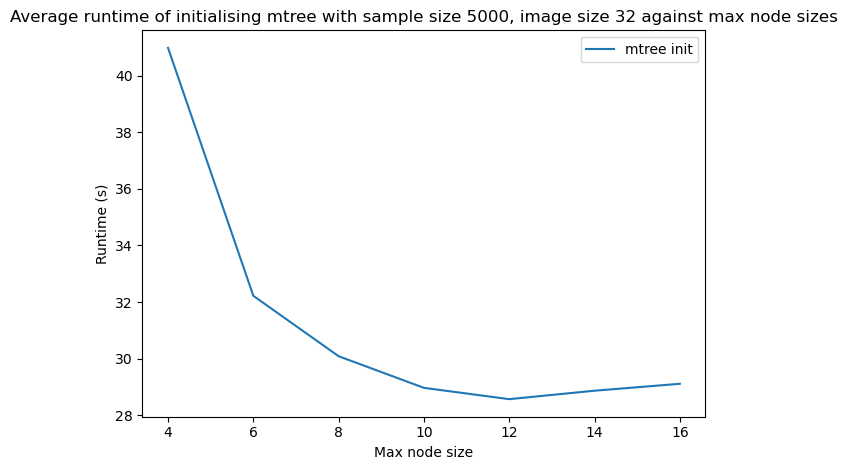

In [54]:
# # importing package
import matplotlib.pyplot as plt
import numpy as np

data_mtree_init = []
for i in range(len(img_sizes)):
    data_mtree_init.append([max_node_sizes[i], avg_times_mtree_init[i]])


data_mtree_init = np.array(data_mtree_init)

x_mtree_init, y_mtree_init = data_mtree_init.T

plt.plot(x_mtree_init, y_mtree_init, label = f"mtree init", linestyle="-")
plt.legend()
plt.xlabel("Max node size")
plt.ylabel("Runtime (s)")
plt.title(f"Average runtime of initialising mtree with sample size {sample_size}, image size {image_size} against max node sizes")
# note its over 3 runs
plt.tight_layout()
plt.savefig("test_mtree_init_max_node_sizes.png", bbox_inches='tight', dpi=1000)
plt.show()

In [81]:
# testing init time for different sample sizes

import time

image_size = 32
#img_size = 32 # length of square images
runs = 1 # number of runs to average result over
k = 7 # number of neighbours
max_node_size = 12 # max node size for MTree
#sample_sizes = [1000, 5000, 10000, 20000, 50000, 100000, 200000, 300000, 400000, 500000]
sample_sizes = [70000]


# total_time_bf  = 0
total_time_mtree_init = 0
avg_times_mtree_init = []


transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

MNIST_data_train = torchvision.datasets.MNIST(root="../data", train=True, transform=transform)
MNIST_data_test = torchvision.datasets.MNIST(root="../data", train=False, transform=transform)
MNIST_data = MNIST_data_train + MNIST_data_test

random.seed(42)
# normally its 500



print(f"Average runtime of initialising mtree over {runs} runs with max node size {max_node_size} and image size {image_size} and variable sample sizes")

for i in range(len(sample_sizes)):
    print(f"NOW TRYING sample size: {sample_sizes[i]}")
    total_time_mtree_init = 0

    sample_indices = random.sample(range(len(MNIST_data)), sample_sizes[i])
    sampled_test_data = Subset(MNIST_data, sample_indices)

    input_dataset = []
    testSample = []
    num = len(sampled_test_data)
    for x in range(len(sampled_test_data)):
        img_tensor = sampled_test_data[x][0]
        input_dataset.append(img_tensor.unsqueeze(0).to(device).float())
        img_numpy = img_tensor.squeeze().squeeze().cpu().numpy().astype(np.float32)
        testSample.append(img_numpy)
        #print(img_numpy)
    
    

    # trans = transforms.Compose([transforms.Resize(img_sizes[i])])
    # t_MNIST_data = trans(MNIST_data)

    # for img in MNIST_data:
    #     img = trans(img)

    for _ in range(runs):
        start_time = time.time()
        tree = getMTree(testSample, max_node_size)
        end_time = time.time()
        total_time_mtree_init += end_time - start_time
        print(f"Finished one run of mtree init...")

    
    avg_mtree_init = total_time_mtree_init / runs
    avg_times_mtree_init.append(avg_mtree_init)

    print(f"Average runtime of mtree init: {avg_mtree_init:.6f} seconds")

Average runtime of initialising mtree over 1 runs with max node size 12 and image size 32 and variable sample sizes
NOW TRYING sample size: 70000
Finished one run of mtree init...
Average runtime of mtree init: 477.132543 seconds


In [ ]:
# # importing package
import matplotlib.pyplot as plt
import numpy as np

data_mtree_init = []
for i in range(len(img_sizes)):
    data_mtree_init.append([sample_sizes[i], avg_times_mtree_init[i]])


data_mtree_init = np.array(data_mtree_init)

x_mtree_init, y_mtree_init = data_mtree_init.T

plt.plot(x_mtree_init, y_mtree_init, label = f"mtree init", linestyle="-")
plt.legend()
plt.xlabel("sample size")
plt.ylabel("Runtime (s)")
plt.title(f"Average runtime of initialising mtree with image size {image_size}, max node size {max_node_size} against sample sizes")
# note its over 3 runs
plt.tight_layout()
plt.savefig("test_mtree_init_sample_sizes.png", bbox_inches='tight', dpi=1000)
plt.show()

## Testing MTreee query time -- differing max node size

In [55]:
# Testing init time for different max node size

import time

image_size = 32
sample_size = 5000 # size of image set
#img_size = 32 # length of square images
runs = 10 # number of runs to average result over
k = 7 # number of neighbours
#max_node_size = 15 # max node size for MTree
max_node_sizes = [4, 6, 8, 10, 12, 14, 16, 18, 20]

# total_time_bf  = 0
total_time_mtree = 0
avg_times_mtree = []

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

MNIST_data_train = torchvision.datasets.MNIST(root="../data", train=True, transform=transform)
MNIST_data_test = torchvision.datasets.MNIST(root="../data", train=False, transform=transform)
MNIST_data = MNIST_data_train + MNIST_data_test

random.seed(42)
# normally its 500
sample_indices = random.sample(range(len(MNIST_data)), sample_size)
sampled_test_data = Subset(MNIST_data, sample_indices)

input_dataset = []
testSample = []
num = len(sampled_test_data)
for x in range(len(sampled_test_data)):
    img_tensor = sampled_test_data[x][0] 
    input_dataset.append(img_tensor.unsqueeze(0).to(device).float())
    img_numpy = img_tensor.squeeze().squeeze().cpu().numpy().astype(np.float32)
    testSample.append(img_numpy)
    #print(img_numpy)


print(f"Average runtime of querying mtree for {k} nearest neighbours over {runs} runs with variable max node size and sample size {sample_size} and image size {image_size} ")

for i in range(len(max_node_sizes)):
    print(f"NOW TRYING max node size: {max_node_sizes[i]}")
    total_time_mtree = 0
    tree = getMTree(testSample, max_node_sizes[i])

    # trans = transforms.Compose([transforms.Resize(img_sizes[i])])
    # t_MNIST_data = trans(MNIST_data)

    # for img in MNIST_data:
    #     img = trans(img)

    for _ in range(runs):
        index1 = np.random.randint(len(MNIST_data))
        #input1=input_dataset[index1][0].squeeze().to('cpu')
        unseen_image = MNIST_data[index1][0].squeeze().squeeze().cpu().numpy().astype(np.float32)

        start_time = time.time()
        imgs = getKNearestNeighbours(tree, unseen_image, k+1)
        end_time = time.time()
        total_time_mtree += end_time - start_time

    
    avg_mtree_init = total_time_mtree_init / runs
    avg_times_mtree_init.append(avg_mtree_init)

    print(f"Average runtime of mtree init: {avg_mtree_init:.6f} seconds")

Average runtime of querying mtree for 7 nearest neighbours over 10 runs with variable max node size and sample size 5000 and image size 32 
NOW TRYING max node size: 4
Average runtime of mtree init: 8.473716 seconds
NOW TRYING max node size: 6
Average runtime of mtree init: 8.473716 seconds
NOW TRYING max node size: 8
Average runtime of mtree init: 8.473716 seconds
NOW TRYING max node size: 10
Average runtime of mtree init: 8.473716 seconds
NOW TRYING max node size: 12
Average runtime of mtree init: 8.473716 seconds
NOW TRYING max node size: 14
Average runtime of mtree init: 8.473716 seconds
NOW TRYING max node size: 16
Average runtime of mtree init: 8.473716 seconds
NOW TRYING max node size: 18
Average runtime of mtree init: 8.473716 seconds
NOW TRYING max node size: 20
Average runtime of mtree init: 8.473716 seconds


In [ ]:
# # importing package
import matplotlib.pyplot as plt
import numpy as np

data_mtree = []
for i in range(len(max_node_sizes)):
    data_mtree.append([sample_sizes[i], avg_times_mtree[i]])


data_mtree = np.array(data_mtree)

x_mtree, y_mtree = data_mtree.T

plt.plot(x_mtree, y_mtree, label = f"mtree search", linestyle="-")
plt.legend()
plt.xlabel("Max node size")
plt.ylabel("Runtime (s)")
plt.title(f"Average runtime of querying mtree for {k} nearest neighbours with sample size {sample_size} and image size {image_size} against max node size")
# note its over 3 runs
plt.tight_layout()
plt.savefig("test_mtree_max_node_sizes.png", bbox_inches='tight', dpi=1000)
plt.show()

## Comparing MTree and Image Product Search -- Differing Image Size

In [ ]:
import time

img_sizes = [32, 64, 128, 140, 150, 180, 200]

sample_size = 5000 # size of image set
#img_size = 32 # length of square images
runs = 10 # number of runs to average result over
k = 7 # number of neighbours
max_node_size = 42 # max node size for MTree

# total_time_bf  = 0
total_time_ncc = 0
total_time_mtree = 0
avg_times_ncc = []
avg_times_mtree = []

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

MNIST_data_train = torchvision.datasets.MNIST(root="../data", train=True, transform=transform)
MNIST_data_test = torchvision.datasets.MNIST(root="../data", train=False, transform=transform)
MNIST_data = MNIST_data_train + MNIST_data_test

random.seed(42)
# normally its 500
sample_indices = random.sample(range(len(MNIST_data)), sample_size)
sampled_test_data = Subset(MNIST_data, sample_indices)

print(f"Average runtime of finding {k} neighbours over {runs} runs with variable image sizes and sample size {sample_size} and mtree with nodes size {max_node_size} ")

for i in range(len(img_sizes)):
    print(f"NOW TRYING image size: {img_sizes[i]}")
    total_time_ncc = 0
    total_time_mtree = 0

    # trans = transforms.Compose([transforms.Resize(img_sizes[i])])
    # t_MNIST_data = trans(MNIST_data)

    # for img in MNIST_data:
    #     img = trans(img)

    transform = transforms.Compose([
    transforms.Resize((img_sizes[i], img_sizes[i])),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

    MNIST_data_train = torchvision.datasets.MNIST(root="../data", train=True, transform=transform)
    MNIST_data_test = torchvision.datasets.MNIST(root="../data", train=False, transform=transform)
    MNIST_data = MNIST_data_train + MNIST_data_test

    random.seed(42)
    # normally its 500
    sample_indices = random.sample(range(len(MNIST_data)), sample_size)
    sampled_test_data = Subset(MNIST_data, sample_indices)


    unseen_image = MNIST_data[-1][0].squeeze().squeeze().cpu().numpy().astype(np.float32)

    input_dataset = []
    testSample = []
    num = len(sampled_test_data)
    for x in range(len(sampled_test_data)):
        img_tensor = sampled_test_data[x][0] 
        input_dataset.append(img_tensor.unsqueeze(0).to(device).float())
        img_numpy = img_tensor.squeeze().squeeze().cpu().numpy().astype(np.float32)
        testSample.append(img_numpy)
        #print(img_numpy)

    tree = getMTree(testSample, max_node_size)

    for _ in range(runs):
        index1 = np.random.randint(len(MNIST_data))
        #input1=input_dataset[index1][0].squeeze().to('cpu')
        unseen_image = MNIST_data[index1][0].squeeze().squeeze().cpu().numpy().astype(np.float32)

        start_time = time.time()
        arr = []
        for j in range(len(testSample)):
            result = ImageProducts.ncc_scaled(testSample[j], unseen_image)
            arr.append(result)
        
        unseen_img_arr = np.array(arr)
        #unseen_img_arr = np.atleast_2d(arr)
        #new_matG = np.append(matrixG, unseen_img_arr, axis=0)
        #print(new_matG[-1])
        #imgProd_max_index = np.argpartition(new_matG[-1], -(k+1))[-(k+1):]
        imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
        end_time = time.time()

        total_time_ncc += end_time - start_time

        start_time = time.time()
        imgs = getKNearestNeighbours(tree, unseen_image, k+1)
        end_time = time.time()
        total_time_mtree += end_time - start_time
    
    avg_ncc = total_time_ncc / runs
    avg_mtree = total_time_mtree / runs
    avg_times_ncc.append(avg_ncc)
    avg_times_mtree.append(avg_mtree)

    print(f"Average runtime of ncc search with image size {img_sizes[i]}: {avg_ncc:.6f} seconds")
    print(f"Average runtime of mtree search with image size {img_sizes[i]}: {avg_mtree:.6f} seconds")
    


Average runtime of finding 7 neighbours over 10 runs with variable image sizes and sample size 5000 and mtree with nodes size 15 
Average runtime of ncc search with image size 32: 0.553354 seconds
Average runtime of mtree search with image size 32: 0.507210 seconds
Average runtime of ncc search with image size 64: 2.386455 seconds
Average runtime of mtree search with image size 64: 2.133756 seconds
Average runtime of ncc search with image size 128: 8.395539 seconds
Average runtime of mtree search with image size 128: 7.606230 seconds
Average runtime of ncc search with image size 140: 8.956767 seconds
Average runtime of mtree search with image size 140: 7.870453 seconds
Average runtime of ncc search with image size 150: 9.824942 seconds
Average runtime of mtree search with image size 150: 8.900700 seconds
Average runtime of ncc search with image size 180: 26.708847 seconds
Average runtime of mtree search with image size 180: 24.005808 seconds
Average runtime of ncc search with image siz

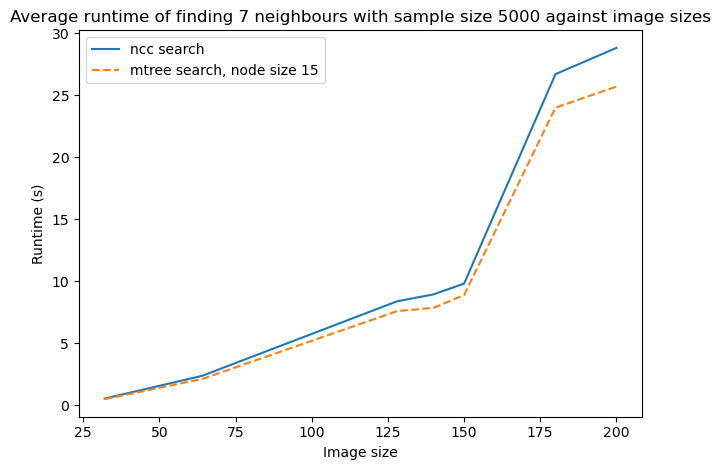

In [ ]:
# # importing package
import matplotlib.pyplot as plt
import numpy as np

data_ncc = []
data_mtree = []
for i in range(len(img_sizes)):
    data_ncc.append([img_sizes[i], avg_times_ncc[i]])
    data_mtree.append([img_sizes[i], avg_times_mtree[i]])

# print(data_ncc)
# print(data_mtree)
data_ncc = np.array(data_ncc)
data_mtree = np.array(data_mtree)
x_ncc, y_ncc = data_ncc.T
x_mtree, y_mtree = data_mtree.T

plt.plot(x_ncc, y_ncc, label = "ncc search", linestyle="-")
plt.plot(x_mtree, y_mtree, label = f"mtree search, node size {max_node_size}", linestyle="--")
plt.legend()
plt.xlabel("Image size")  # Title for the x-axis
plt.ylabel("Runtime (s)")  # Title for the y-axis
plt.title(f"Average runtime of finding {k} neighbours with sample size {sample_size} against image sizes")
# note its over 10 runs
plt.tight_layout()
plt.savefig("test_mtree_img_sizes.png", bbox_inches='tight', dpi=1000)

plt.show()


## Comparing MTree and Image Product Search -- Differing Sample Size

In [ ]:
# testing query time for different sample sizes

import time

image_size = 32
#img_size = 32 # length of square images
runs = 5 # number of runs to average result over
k = 7 # number of neighbours
max_node_size = 15 # max node size for MTree
sample_sizes = [1000, 5000, 10000, 20000, 50000, 100000, 200000, 300000, 400000, 500000]


# total_time_bf  = 0
total_time_ncc = 0
total_time_mtree = 0
avg_times_ncc = []
avg_times_mtree = []


transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

MNIST_data_train = torchvision.datasets.MNIST(root="../data", train=True, transform=transform)
MNIST_data_test = torchvision.datasets.MNIST(root="../data", train=False, transform=transform)
MNIST_data = MNIST_data_train + MNIST_data_test

random.seed(42)



print(f"Average runtime of querying mtree and ncc for {k} NN over {runs} runs with image size {image_size} and max node size {max_node_size} and variable sample size")

for i in range(len(sample_sizes)):
    print(f"NOW TRYING sample size: {sample_sizes[i]}")
    total_time_ncc = 0
    total_time_mtree = 0

    sample_indices = random.sample(range(len(MNIST_data)), sample_size[i])
    sampled_test_data = Subset(MNIST_data, sample_indices)

    input_dataset = []
    testSample = []
    num = len(sampled_test_data)
    for x in range(len(sampled_test_data)):
        img_tensor = sampled_test_data[x][0]
        input_dataset.append(img_tensor.unsqueeze(0).to(device).float())
        img_numpy = img_tensor.squeeze().squeeze().cpu().numpy().astype(np.float32)
        testSample.append(img_numpy)
        #print(img_numpy)
    
    tree = getMTree(testSample[i], max_node_size)

    # trans = transforms.Compose([transforms.Resize(img_sizes[i])])
    # t_MNIST_data = trans(MNIST_data)

    # for img in MNIST_data:
    #     img = trans(img)

    for _ in range(runs):
        index1 = np.random.randint(len(MNIST_data))
        #input1=input_dataset[index1][0].squeeze().to('cpu')
        unseen_image = MNIST_data[index1][0].squeeze().squeeze().cpu().numpy().astype(np.float32)

        start_time = time.time()
        arr = []
        for j in range(len(testSample)):
            result = ImageProducts.ncc_scaled(testSample[j], unseen_image)
            arr.append(result)
        
        unseen_img_arr = np.array(arr)
        #unseen_img_arr = np.atleast_2d(arr)
        #new_matG = np.append(matrixG, unseen_img_arr, axis=0)
        #print(new_matG[-1])
        #imgProd_max_index = np.argpartition(new_matG[-1], -(k+1))[-(k+1):]
        imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
        end_time = time.time()

        total_time_ncc += end_time - start_time

        start_time = time.time()
        imgs = getKNearestNeighbours(tree, unseen_image, k+1)
        end_time = time.time()
        total_time_mtree += end_time - start_time
    
    avg_ncc = total_time_ncc / runs
    avg_mtree = total_time_mtree / runs
    avg_times_ncc.append(avg_ncc)
    avg_times_mtree.append(avg_mtree)

    print(f"Average runtime of ncc search: {avg_ncc:.6f} seconds")
    print(f"Average runtime of mtree search: {avg_mtree:.6f} seconds")

In [ ]:
# # importing package
import matplotlib.pyplot as plt
import numpy as np

data_ncc = []
data_mtree = []
for i in range(len(img_sizes)):
    data_ncc.append([img_sizes[i], avg_times_ncc[i]])
    data_mtree.append([img_sizes[i], avg_times_mtree[i]])

# print(data_ncc)
# print(data_mtree)
data_ncc = np.array(data_ncc)
data_mtree = np.array(data_mtree)
x_ncc, y_ncc = data_ncc.T
x_mtree, y_mtree = data_mtree.T

plt.plot(x_ncc, y_ncc, label = "ncc search", linestyle="-")
plt.plot(x_mtree, y_mtree, label = f"mtree search, node size {max_node_size}", linestyle="--")
plt.legend()
plt.xlabel("Sample size")  # Title for the x-axis
plt.ylabel("Runtime (s)")  # Title for the y-axis
plt.title(f"Average runtime of finding {k} neighbours with image size {image_size} against sample sizes")
# note its over 5 runs
plt.tight_layout()
plt.savefig("test_mtree_sample_sizes.png", bbox_inches='tight', dpi=1000)

plt.show()

## Comparing MTree and Image Product Search -- Differing k (Number of nearest neighbours)

In [ ]:
# testing init time for different k

import time

image_size = 32
#img_size = 32 # length of square images
runs = 5 # number of runs to average result over
max_node_size = 15 # max node size for MTree
sample_sizes = 5000
ks = [1,2,3,4,5,6,7,8,9,10] # number of neighbours



# total_time_bf  = 0
total_time_ncc = 0
total_time_mtree = 0
avg_times_ncc = []
avg_times_mtree = []



transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

MNIST_data_train = torchvision.datasets.MNIST(root="../data", train=True, transform=transform)
MNIST_data_test = torchvision.datasets.MNIST(root="../data", train=False, transform=transform)
MNIST_data = MNIST_data_train + MNIST_data_test

random.seed(42)



print(f"Average runtime of querying mtree and ncc for varying k NNs over {runs} runs with image size {image_size} and max node size {max_node_size} and sample size {sample_size}")

for i in range(len(sample_sizes)):
    print(f"NOW TRYING k: {ks[i]}")
    total_time_ncc = 0
    total_time_mtree = 0
    total_time_mtree_init = 0

    sample_indices = random.sample(range(len(MNIST_data)), sample_size[i])
    sampled_test_data = Subset(MNIST_data, sample_indices)

    input_dataset = []
    testSample = []
    num = len(sampled_test_data)
    for x in range(len(sampled_test_data)):
        img_tensor = sampled_test_data[x][0]
        input_dataset.append(img_tensor.unsqueeze(0).to(device).float())
        img_numpy = img_tensor.squeeze().squeeze().cpu().numpy().astype(np.float32)
        testSample.append(img_numpy)
        #print(img_numpy)
    
    tree = getMTree(testSample[i], max_node_size)

    # trans = transforms.Compose([transforms.Resize(img_sizes[i])])
    # t_MNIST_data = trans(MNIST_data)

    # for img in MNIST_data:
    #     img = trans(img)

    for _ in range(runs):
        index1 = np.random.randint(len(MNIST_data))
        #input1=input_dataset[index1][0].squeeze().to('cpu')
        unseen_image = MNIST_data[index1][0].squeeze().squeeze().cpu().numpy().astype(np.float32)

        start_time = time.time()
        arr = []
        for j in range(len(testSample)):
            result = ImageProducts.ncc_scaled(testSample[j], unseen_image)
            arr.append(result)
        
        unseen_img_arr = np.array(arr)
        #unseen_img_arr = np.atleast_2d(arr)
        #new_matG = np.append(matrixG, unseen_img_arr, axis=0)
        #print(new_matG[-1])
        #imgProd_max_index = np.argpartition(new_matG[-1], -(k+1))[-(k+1):]
        imgProd_max_index = np.argpartition(unseen_img_arr, -(ks[i]+1))[-(ks[i]+1):]
        end_time = time.time()

        total_time_ncc += end_time - start_time

        start_time = time.time()
        imgs = getKNearestNeighbours(tree, unseen_image, ks[i]+1)
        end_time = time.time()
        total_time_mtree += end_time - start_time
    
    avg_ncc = total_time_ncc / runs
    avg_mtree = total_time_mtree / runs
    avg_times_ncc.append(avg_ncc)
    avg_times_mtree.append(avg_mtree)

    print(f"Average runtime of ncc search: {avg_ncc:.6f} seconds")
    print(f"Average runtime of mtree search: {avg_mtree:.6f} seconds")

In [ ]:
# # importing package
import matplotlib.pyplot as plt
import numpy as np

data_ncc = []
data_mtree = []
for i in range(len(img_sizes)):
    data_ncc.append([img_sizes[i], avg_times_ncc[i]])
    data_mtree.append([img_sizes[i], avg_times_mtree[i]])

# print(data_ncc)
# print(data_mtree)
data_ncc = np.array(data_ncc)
data_mtree = np.array(data_mtree)
x_ncc, y_ncc = data_ncc.T
x_mtree, y_mtree = data_mtree.T

plt.plot(x_ncc, y_ncc, label = "ncc search", linestyle="-")
plt.plot(x_mtree, y_mtree, label = f"mtree search, node size {max_node_size}", linestyle="--")
plt.legend()
plt.xlabel("k number of neighbours")  # Title for the x-axis
plt.ylabel("Runtime (s)")  # Title for the y-axis
plt.title(f"Average runtime of finding variable neighbours with image size {image_size} and sample size {sample_size}")
# note its over 5 runs
plt.tight_layout()
plt.savefig("test_mtree_k_number.png", bbox_inches='tight', dpi=1000)

plt.show()